# Importing Dependencies

In [19]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import Dataset, DataLoader
import pickle
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import torch
import os
from PIL import Image
from torch.utils.data import Dataset

# Set random seed for reproducibility
seed = 6969
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  6969


# Datasets

In [20]:
class ImageDataset(Dataset):
  def __init__(self,images,transformer=None):
    self.images=images
    self.transformer=transformer
  def __len__(self):
    return(len(self.images))
  def __getitem__(self,idx):
    image=self.images[idx]
    path_of_image=(f"Batik300/images/{image}")
    image=Image.open(path_of_image).convert('RGB')
    if self.transformer is not None:
      image=self.transformer(image)
    return image

# Preprocessing

In [21]:
# image_size = 256
# transformer = transforms.Compose([
#                                 transforms.Resize(image_size),
#                                 transforms.CenterCrop(image_size),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
#                                 ])

image_size=256
transformer = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(10),  # Rotasi random
    transforms.RandomHorizontalFlip(),  # Flip horizontal
    transforms.RandomVerticalFlip(),  # Flip vertikal
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Crop acak
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Creating Datasets

In [22]:
# Membaca nama file dari folder images_correct
images = os.listdir('Batik300/images')  # Ini akan memberikan daftar nama file
dataset = ImageDataset(images, transformer)

In [23]:
print(len(images))  # Check the number of images in the folder

20500


# Show the image

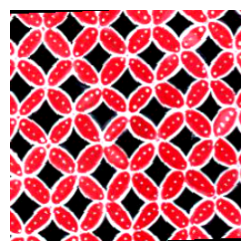

In [24]:
# Convert the tensor to a PIL image
image=dataset[44]
denormalize = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])  # Reverse the normalization
])
image_denormalized = denormalize(image)
image = transforms.ToPILImage()(image_denormalized)
plt.figure(figsize=(3,3))
# Display the image

plt.imshow(image)
plt.axis('off')
plt.show()

In [25]:
# batch_size=32
# dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
# next(iter(dataloader)).shape

batch_size=64
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
next(iter(dataloader)).shape

torch.Size([64, 3, 256, 256])

In [26]:
# # import torch.nn as nn
# # import torch

# # image_size = 256
# # nz = 100  # Dimensi dari noise vector
# # ngf = 64  # Ukuran fitur pada Generator
# # ndf = 64  # Ukuran fitur pada Discriminator
# # nc = 3    # Jumlah channel (3 untuk gambar RGB)

# # class Generator(nn.Module):
# #     def __init__(self):
# #         super(Generator, self).__init__()
# #         self.main = nn.Sequential(
# #             nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
# #             nn.BatchNorm2d(ngf * 16),
# #             nn.ReLU(True),

# #             nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ngf * 8),
# #             nn.ReLU(True),

# #             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ngf * 4),
# #             nn.ReLU(True),

# #             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ngf * 2),
# #             nn.ReLU(True),

# #             nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ngf),
# #             nn.ReLU(True),

# #             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
# #             nn.Tanh()
# #         )

# #     def forward(self, input):
# #         return self.main(input)

# nz=128
# ngf=64
# ndf=64
# nc=3
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator,self).__init__()
#         self.main=nn.Sequential(
#             nn.ConvTranspose2d(nz,ngf*8,4,1,0,bias=False),
#             nn.BatchNorm2d(ngf*8),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
#             nn.BatchNorm2d(ngf*4),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
#             nn.BatchNorm2d(ngf*2),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
#             nn.Tanh()
#         )
#     def forward(self,input):
#         return self.main(input)


In [27]:
nz = 100  # Dimensi dari noise vector
ngf = 64  # Ukuran fitur pada Generator
ndf = 64  # Ukuran fitur pada Discriminator
nc = 3    # Jumlah channel (3 untuk gambar RGB)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),  # Output: (ngf*16) x 4 x 4
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),  # Output: (ngf*8) x 8 x 8
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # Output: (ngf*4) x 16 x 16
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # Output: (ngf*2) x 32 x 32
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # Output: (ngf) x 64 x 64
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, ngf // 2, 4, 2, 1, bias=False),  # Output: (ngf//2) x 128 x 128
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf // 2, nc, 4, 2, 1, bias=False),  # Output: (nc) x 256 x 256
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf // 2, 4, 2, 1, bias=False),  # Output: (ndf//2) x 128 x 128
            nn.BatchNorm2d(ndf // 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf // 2, ndf, 4, 2, 1, bias=False),  # Output: (ndf) x 64 x 64
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # Output: (ndf*2) x 32 x 32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # Output: (ndf*4) x 16 x 16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # Output: (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),  # Output: (ndf*16) x 4 x 4
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),  # Output: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [28]:
# # class Discriminator(nn.Module):
# #     def __init__(self):
# #         super(Discriminator, self).__init__()
# #         self.main = nn.Sequential(
# #             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
# #             nn.LeakyReLU(0.2, inplace=True),

# #             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ndf * 2),
# #             nn.LeakyReLU(0.2, inplace=True),

# #             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ndf * 4),
# #             nn.LeakyReLU(0.2, inplace=True),

# #             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ndf * 8),
# #             nn.LeakyReLU(0.2, inplace=True),

# #             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
# #             nn.BatchNorm2d(ndf * 16),
# #             nn.LeakyReLU(0.2, inplace=True),

# #             nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
# #             nn.Sigmoid()
# #         )

# #     def forward(self, input):
# #         return self.main(input).view(input.size(0))

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator,self).__init__()
#         self.main=nn.Sequential(
#             nn.Conv2d(nc,ndf*8,4,2,1,bias=False),
#             nn.BatchNorm2d(ndf*8),
#             nn.LeakyReLU(0.2,inplace=True),
            
#             nn.Conv2d(ndf*8,ndf*4,4,2,1,bias=False),
#             nn.BatchNorm2d(ndf*4),
#             nn.LeakyReLU(0.2,inplace=True),
            
#             nn.Conv2d(ndf*4,ndf*2,4,2,1,bias=False),
#             nn.BatchNorm2d(ndf*2),
#             nn.LeakyReLU(0.2,inplace=True),
            
#             nn.Conv2d(ndf*2,ndf,4,2,1,bias=False),
#             nn.BatchNorm2d(ndf),
#             nn.LeakyReLU(0.2,inplace=True),
            
#             nn.Conv2d(ndf,1,4,1,0,bias=False),
#             nn.Sigmoid()
#         )
        
#     def forward(self,input):
#         return self.main(input)

In [29]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
discriminator=Discriminator().to(device)
generator=Generator().to(device)

In [31]:
from torchsummary import summary

print("Generator Summary:")
summary(generator, (nz, 1, 1))  # Input size untuk Generator

print("\nDiscriminator Summary:")
summary(discriminator, (nc, 256, 256))  # Input size untuk Discriminator

Generator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14

In [32]:
fixed_noise=torch.randn(64,nz,1,1)

In [33]:
lr=0.001
loss=nn.BCELoss()
optim_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))
optim_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))

In [34]:
class EarlyStopping:
    def __init__(self, patience=100, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def should_stop(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience


In [35]:
import time

# Definisikan loop training dengan WGAN
def training_loop(dataloader, generator, discriminator, epochs, optim_g, optim_d, device, patience=5, min_delta=0.001, weight_clip_value=0.01):
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(epochs):
        print(f'----------------Epoch {epoch + 1}-----------------')
        start_time = time.time()  # Start timer for the epoch

        generator.train()
        discriminator.train()
        
        epoch_gen_loss = 0  # Track generator loss per epoch for early stopping
        epoch_disc_loss = 0  # Track discriminator loss per epoch
        for images in dataloader:
            images = images.to(device)
            batch = len(images)

            # Train discriminator
            optim_d.zero_grad()
            D_R = discriminator(images).view(-1)
            real_loss = -torch.mean(D_R)
            
            noise = torch.randn(batch, nz, 1, 1, device=device)
            G_I = generator(noise)
            D_F = discriminator(G_I.detach()).view(-1)
            fake_loss = torch.mean(D_F)
            
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            optim_d.step()

            # Apply weight clipping to discriminator
            for p in discriminator.parameters():
                p.data.clamp_(-weight_clip_value, weight_clip_value)

            epoch_disc_loss += disc_loss.item()  # Sum discriminator loss

            # Train generator
            optim_g.zero_grad()
            G_F = discriminator(G_I).view(-1)
            gen_loss = -torch.mean(G_F)
            gen_loss.backward()
            optim_g.step()

            epoch_gen_loss += gen_loss.item()  # Sum generator loss

        # Calculate average generator and discriminator loss for the epoch
        avg_gen_loss = epoch_gen_loss / len(dataloader)
        avg_disc_loss = epoch_disc_loss / len(dataloader)

        # Calculate time taken for the epoch
        epoch_time = time.time() - start_time

        # Print average losses and time per epoch
        print(f"Epoch {epoch + 1} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}, Time: {epoch_time:.2f}s")

        # Early stopping check
        if early_stopping.should_stop(avg_gen_loss):
            print(f"Early stopping at epoch {epoch + 1}")
            break
        
# Fungsi untuk menyimpan gambar palsu dari generator
def save_fake_images(generator, num_images, fake_images_path, device):
    os.makedirs(fake_images_path, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i in range(num_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake_image = generator(noise).detach().cpu()
            img = transforms.ToPILImage()(fake_image[0])
            img.save(f'{fake_images_path}/fake_{i}.jpg')


In [36]:
from pytorch_fid import fid_score
import os
import torchvision.transforms as transforms
from PIL import Image

# Tentukan paths untuk gambar nyata dan gambar palsu
real_images_path = 'Batik300'
fake_images_path = 'Batik300_fake'

# Atur optimizer dengan learning rate generator lebih rendah
lr = 0.001
optim_g = torch.optim.Adam(generator.parameters(), lr=lr / 10, betas=(0.5, 0.999))
optim_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Pelatihan GAN
epochs = 100  # contoh jumlah epoch    
training_loop(dataloader, generator, discriminator, epochs, optim_g, optim_d, device=device)

# Simpan gambar palsu untuk evaluasi FID
num_images_to_generate = 100  # contoh jumlah gambar palsu
save_fake_images(generator, num_images_to_generate, fake_images_path, device=device)



----------------Epoch 1-----------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 43.00 MiB is free. Including non-PyTorch memory, this process has 3.75 GiB memory in use. Of the allocated memory 3.60 GiB is allocated by PyTorch, and 66.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Hitung FID
fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=128, device=device, dims=2048)
print(f"FID Score: {fid_value}")

# Simpan gambar palsu
save_fake_images(generator, 100, fake_images_path)

# Hitung FID antara real_images_path dan fake_images_path
fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=128, device=device, dims=2048)
print(f"FID Score: {fid_value}")

ValueError: batch_size should be a positive integer value, but got batch_size=0

In [ ]:
torch.save(generator.state_dict(), 'model_weight/generator_weights.pth')
torch.save(discriminator.state_dict(), 'model_weight/discriminator_weights.pth')

In [ ]:
import torch

# Assuming 'generator' and 'discriminator' models are already defined
generator.load_state_dict(torch.load('model_weight/generator_weights.pth'))
discriminator.load_state_dict(torch.load('model_weight/discriminator_weights.pth'))

# Set the models to evaluation mode if you are not training
generator.eval()
discriminator.eval()


/tmp/ipykernel_7548/2377490902.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('model_weight/generator_weights.pth'))
/tmp/ipykernel

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4

In [ ]:
from pytorch_fid import fid_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
real_images_path = 'Batik300'
fake_images_path = 'coba'

# Function to save fake images from the generator
def save_fake_images(generator, num_images, fake_images_path):
    os.makedirs(fake_images_path, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i in range(num_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake_image = generator(noise).detach().cpu()
            img = transforms.ToPILImage()(fake_image[0])
            img.save(f'{fake_images_path}/fake_{i}.jpg')

# Generate fake images for FID evaluation
num_images_to_generate = 100  # Example number of fake images
save_fake_images(generator, num_images_to_generate, fake_images_path)

# Calculate FID
fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=32, device=device, dims=2048)
print(f"FID Score: {fid_value}")


ValueError: batch_size should be a positive integer value, but got batch_size=0

In [ ]:
# generator.eval()
# images=generator(torch.randn(1,100,1,1).to(device))
# # Convert the tensor to a PIL image
# image = transforms.ToPILImage()(images[0])
# plt.figure(figsize=(3,3))
# # Display the image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

# # Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# generator.cpu()
# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(vutils.make_grid(generator(torch.randn(64,100,1,1)), padding=5, normalize=True).cpu(),(1,2,0)))
# plt.show()

In [ ]:
# noise=torch.randn(1,100,1,1)

# generator.eval()
# images=generator(noise)
# # Convert the tensor to a PIL image
# image = transforms.ToPILImage()(images[0])
# plt.figure(figsize=(3,3))
# # Display the image
# plt.imshow(image)
# plt.axis('off')
# plt.show()


# generator.eval()
# images = generator(noise)
# denormalize = transforms.Compose([
#     transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])  # Reverse the normalization
# ])
# images_denormalized = denormalize(images)
# image = transforms.ToPILImage()(images_denormalized[0])
# plt.figure(figsize=(3, 3))
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [ ]:
# with open('generator.pkl', 'wb') as file:
#     pickle.dump(generator, file)

In [ ]:
print('helo')

helo
